<a href="https://colab.research.google.com/github/rzqynptr/Matematika-Diskrit-24083010042-Amelia/blob/main/24083010042_Amelia_Rizqyna_Putri_Matdis_Tugas_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== HASIL ANALISIS SIMULASI ===
>> (1) Pola Makan Sehat
Jumlah individu dengan pola sehat : 119
indeks pola sehat (maks 20): [0, 1, 2, 12, 14, 20, 21, 30, 31, 39, 41, 53, 57, 58, 63, 64, 65, 71, 72, 73]

>> (2) Pola Sehat sekaligus Hemat
Jumlah individu pola sehat & hemat : 119
indeks kandidat (maks 20): [0, 1, 2, 12, 14, 20, 21, 30, 31, 39, 41, 53, 57, 58, 63, 64, 65, 71, 72, 73]

>> (3) Pola Juara (Skor Tertinggi)
Pola terbaik terdapat pada ID : 39
   Skor Total : 101.840
   Skor Sehat : 3.600
   Sisa Budget: Rp 124,000

>> (4) Jadwal Konsumsi Harian (31 Hari)
   Hari  Menu Pagi Menu Malam
 Hari 1       roti     warteg
 Hari 2 nasipadang mi instan 
 Hari 3      bakso mi instan 
 Hari 4     warteg nasipadang
 Hari 5     cireng nasigoreng
 Hari 6     capcay     capcay
 Hari 7     capcay    mieayam
 Hari 8 nasigoreng mi instan 
 Hari 9     cireng mi instan 
Hari 10       roti      bakso
Hari 11    mieayam ayamgeprek
Hari 12 nasigoreng mi instan 
Hari 13 ayamgeprek     seblak
Hari 14 ay

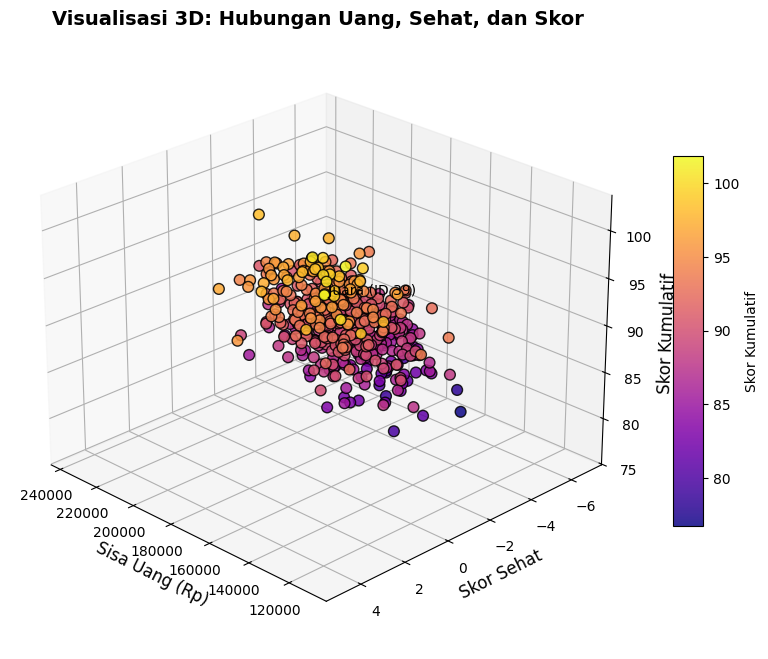

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Konfigurasi ----------
NPM = 19102
np.random.seed(NPM)

makan = pd.read_csv("makanan.csv")
# Pastikan kolom yang diperlukan ada:
# 'makanan', 'harga', 'kenyang', 'rasa', 'sehat', 'bosan'

# Isi NaN dengan nilai default supaya aman
for col in ['harga', 'kenyang', 'rasa', 'sehat', 'bosan']:
    if col in makan.columns:
        makan[col] = makan[col].fillna(makan[col].mean())

HARI = 31
SAMPLE_NUM = 500

budget_awal = 1e6  # rupiah

wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9
wbosan_base = 0.2

SISA_MININUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM + 1000, 1000)

# Arrays untuk menyimpan hasil simulasi
sampleid = np.arange(0, SAMPLE_NUM)
skor = np.zeros(SAMPLE_NUM, dtype=np.double)       # skor kumulatif
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)       # sisa budget
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)      # skor kesehatan kumulatif
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.full((SAMPLE_NUM, HARI * 2), np.nan, dtype=float)  # NaN jika kosong

# --------- Simulasi ----------
for n in range(SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0.0
    skor_sehat = 0.0

    for i in range(HARI):
        # makan pertama (pagi)
        pilihan = np.random.randint(0, len(makan))
        # update weight factor (acak tiap makanan)
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
            + w_rasa * makan['rasa'].iloc[pilihan]
            + w_sehat * makan['sehat'].iloc[pilihan]
            - w_bosan * makan['bosan'].iloc[pilihan]
        )
        skor_sehat += makan['sehat'].iloc[pilihan] - 0.5
        budget -= makan['harga'].iloc[pilihan]
        resp_pilih[n, 2 * i] = pilihan

        # makan kedua (malam)
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base + 0.2, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base * 2, scale=0.2)

        skor_kumulatif += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
            + w_rasa * makan['rasa'].iloc[pilihan]
            + w_sehat * makan['sehat'].iloc[pilihan]
            - w_bosan * makan['bosan'].iloc[pilihan]
        )
        skor_sehat += makan['sehat'].iloc[pilihan] - 0.5
        budget -= makan['harga'].iloc[pilihan]
        resp_pilih[n, 2 * i + 1] = pilihan

    # simpan hasil per sample
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    # simpan resp_sehat ke bin yang sesuai (clamp index agar tidak out-of-bounds)
    idx = int(round((budget - SISA_MININUM) / 1000))
    idx_clamped = max(0, min(idx, len(bin_sisa) - 1))
    resp_sehat[n, idx_clamped] = skor_sehat

# --------- Analisis hasil ----------
print("\n=== HASIL ANALISIS SIMULASI ===")

# (1) Pola sehat (skor sehat > 0)
pola_sehat = [i for i, val in enumerate(sehat) if val > 0]
print(">> (1) Pola Makan Sehat")
print(f"Jumlah individu dengan pola sehat : {len(pola_sehat)}")
print(f"indeks pola sehat (maks 20): {pola_sehat[:20]}\n")

# (2) Pola sehat & hemat (sehat > 0 dan masih ada sisa budget positif)
pola_sehat_hemat = [i for i in pola_sehat if sisa[i] > 0]
print(">> (2) Pola Sehat sekaligus Hemat")
print(f"Jumlah individu pola sehat & hemat : {len(pola_sehat_hemat)}")
print(f"indeks kandidat (maks 20): {pola_sehat_hemat[:20]}\n")

# (3) Cari juara (skor tertinggi dari kandidat)
print(">> (3) Pola Juara (Skor Tertinggi)")
if pola_sehat_hemat:
    id_juara = max(pola_sehat_hemat, key=lambda idx: skor[idx])
    print(f"Pola terbaik terdapat pada ID : {id_juara}")
    print(f"   Skor Total : {skor[id_juara]:,.3f}")
    print(f"   Skor Sehat : {sehat[id_juara]:,.3f}")
    print(f"   Sisa Budget: Rp {int(sisa[id_juara]):,}\n")

    # (4) Buat tabel jadwal makan harian
    print(">> (4) Jadwal Konsumsi Harian (31 Hari)")
    pilihan_menu = resp_pilih[id_juara]
    jadwal_data = []
    for hari in range(HARI):
        idx_pagi = pilihan_menu[2 * hari]
        idx_malam = pilihan_menu[2 * hari + 1]

        if pd.notna(idx_pagi) and 0 <= int(idx_pagi) < len(makan):
            menu_pagi = makan['makanan'].iloc[int(idx_pagi)]
        else:
            menu_pagi = "—"

        if pd.notna(idx_malam) and 0 <= int(idx_malam) < len(makan):
            menu_malam = makan['makanan'].iloc[int(idx_malam)]
        else:
            menu_malam = "—"

        jadwal_data.append([f"Hari {hari+1}", menu_pagi, menu_malam])

    df_jadwal = pd.DataFrame(jadwal_data, columns=["Hari", "Menu Pagi", "Menu Malam"])
    print(df_jadwal.to_string(index=False))
else:
    print("Tidak ada individu yang memenuhi syarat sehat & hemat.\n")

# --------- Visualisasi 3D ----------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter semua titik
p = ax.scatter(
    sisa, sehat, skor,
    c=skor, cmap="plasma",
    s=60, alpha=0.85, edgecolor="k"
)

# Tandai pola juara bila ada
if 'id_juara' in locals():
    ax.scatter(
        sisa[id_juara], sehat[id_juara], skor[id_juara],
        marker="*", s=200, edgecolor="black", linewidth=1.5
    )
    ax.text(
        sisa[id_juara], sehat[id_juara], skor[id_juara],
        f" Juara (ID {id_juara})", fontsize=10, zorder=10
    )

ax.set_xlabel("Sisa Uang (Rp)", fontsize=12)
ax.set_ylabel("Skor Sehat", fontsize=12)
ax.set_zlabel("Skor Kumulatif", fontsize=12)
ax.set_title("Visualisasi 3D: Hubungan Uang, Sehat, dan Skor", fontsize=14, fontweight="bold")

fig.colorbar(p, ax=ax, shrink=0.6, aspect=12, label="Skor Kumulatif")
ax.view_init(elev=25, azim=135)
plt.show()